In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from fastai.imports import *
from fastai.core import *
from fastai.io import *
from fastai.dataloader import *
from fastai.conv_learner import *
from fastai.learner import *
import os
from audio_dataset import *

import IPython.display as ipd

In [2]:
import librosa

## Load Data

In [3]:
PATH = Path('data/freesound')
TRN_PATH = PATH/'audio_train'
TEST_PATH = PATH/'audio_test'

In [4]:
list(PATH.iterdir())

[PosixPath('data/freesound/sample_submission.csv'),
 PosixPath('data/freesound/models'),
 PosixPath('data/freesound/train.csv'),
 PosixPath('data/freesound/audio_train'),
 PosixPath('data/freesound/audio_test'),
 PosixPath('data/freesound/tmp')]

In [5]:
trn = pd.read_csv(PATH/'train.csv')
test = pd.read_csv(PATH/'sample_submission.csv')

In [6]:
trn.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [7]:
trn.shape[0], len(trn.label.unique())

(9473, 41)

In [8]:
fnames = list(trn['fname']) 
len(fnames), fnames[:5]

(9473,
 ['00044347.wav',
  '001ca53d.wav',
  '002d256b.wav',
  '0033e230.wav',
  '00353774.wav'])

In [10]:
trn_wavs = (PATH/'audio_train').glob('*.wav')
test_wavs = (PATH/'audio_test').glob('*.wav')

In [11]:
aud = get_audio(next(trn_wavs)); aud.shape

(1, 128, 128)

### Distribution of Categories

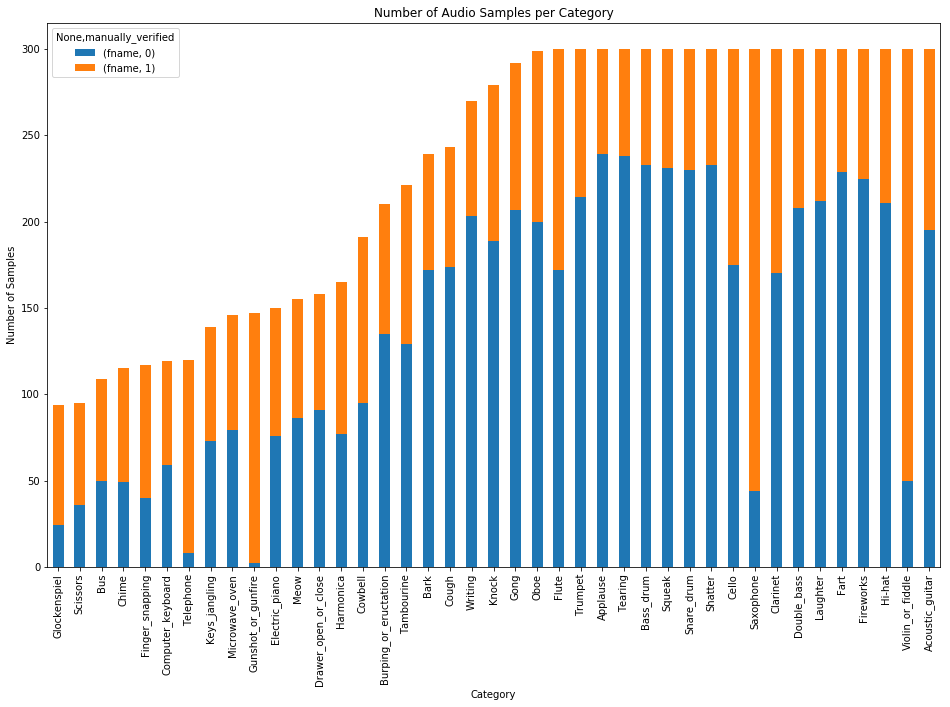

In [11]:
cat_grp = trn.groupby(['label', 'manually_verified']).count()
plot = cat_grp.unstack().reindex(cat_grp.unstack().sum(axis=1).sort_values().index).plot(
    kind='bar', stacked=True, title='Number of Audio Samples per Category', figsize=(16,10))
plot.set_xlabel('Category')
plot.set_ylabel('Number of Samples');

Fairly small percentage of "manually verified" sound clips.

In [12]:
print('Minimum samples in a category:', min(trn.label.value_counts()))
print('Maximum samples in a category:', max(trn.label.value_counts()))

Minimum samples in a category: 94
Maximum samples in a category: 300


In [13]:
import wave

f = str(PATH/'audio_train/001ca53d.wav')
wav = wave.open(f)
print('Sampling (frame) rate:', wav.getframerate())
print('Total samples (frames):', wav.getnframes())
print('Duration:', wav.getnframes()/wav.getframerate())

Sampling (frame) rate: 44100
Total samples (frames): 455112
Duration: 10.32


In [14]:
#import torchaudio -- torchaudio not available in Fastai environment
# using scipy
from scipy.io import wavfile
rate, data = wavfile.read(f)
print('Sampling (frame) rate:', rate)
print('Total samples (frames):', data.shape)
print(data)

Sampling (frame) rate: 44100
Total samples (frames): (455112,)
[-33 -32 -34 ...,  -1  -1  -1]


Plot audio frames

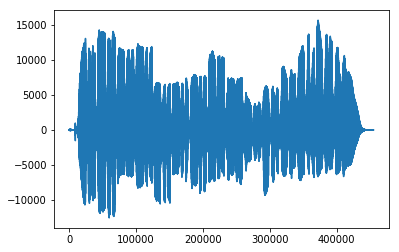

In [15]:
plt.plot(data, '-', );

Zoom in to view 250 frames

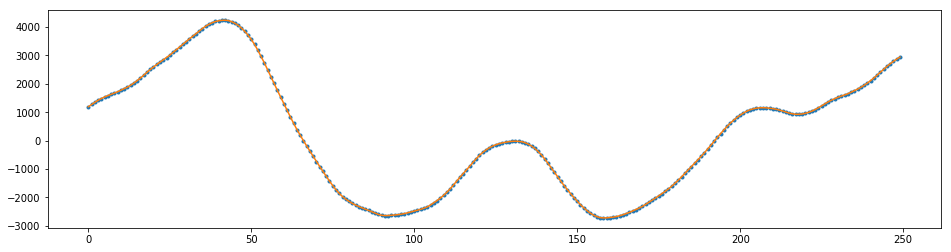

In [16]:
plt.figure(figsize=(16,4))
plt.plot(data[25250:25500], '.'); plt.plot(data[25250:25500], '-');

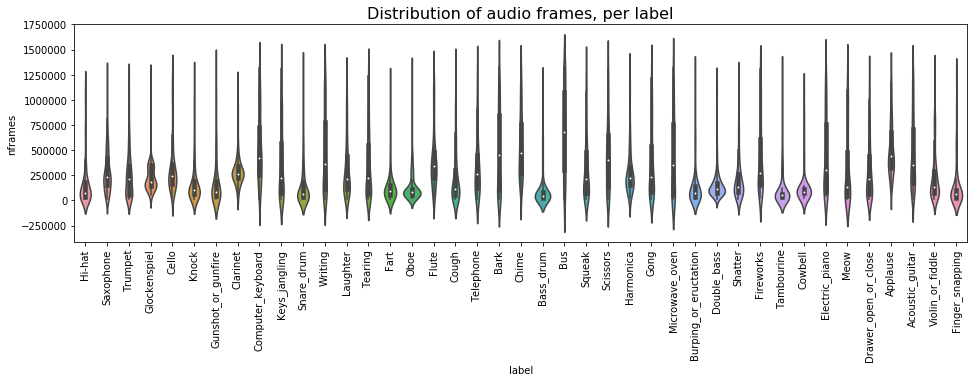

In [17]:
trn['nframes'] = trn['fname'].apply(lambda f: wave.open('data/freesound/audio_train/'+f).getnframes())
test['nframes'] = test['fname'].apply(lambda f: wave.open('data/freesound/audio_test/'+f).getnframes())

_,ax = plt.subplots(figsize=(16,4))
sns.violinplot(ax=ax, x='label', y='nframes', data=trn)
plt.xticks(rotation=90)
plt.title('Distribution of audio frames, per label', fontsize=16)
plt.show()

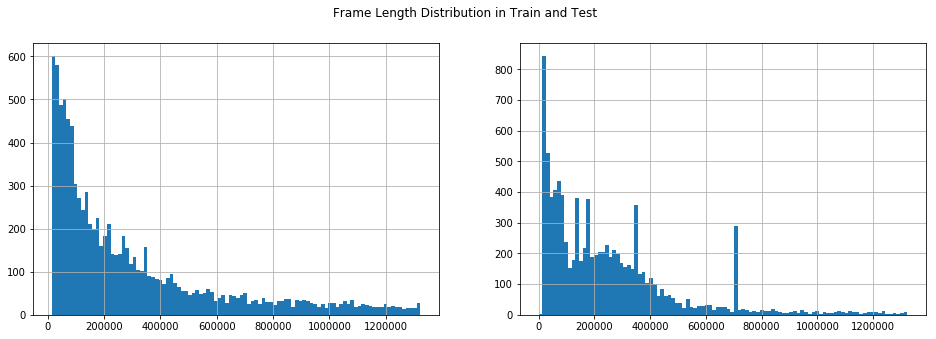

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
trn.nframes.hist(bins=100, ax=axes[0])
test.nframes.hist(bins=100, ax=axes[1])
plt.suptitle("Frame Length Distribution in Train and Test", ha='center', fontsize='large');

1. The majority of frame lengths are short.
2. There are 4 abnormal lengths in test set. Let's analyze them.

### Listen to Sounds

TODO: Warning suggests there is a problem with melspectrogram parameters. Also, I thought I had it worked out so that it would return a square melspectrogram for each image [256,256], but it's not working out that way. Some are, but many are not.

In [12]:
from librosa import display

In [13]:
sample = next(trn_wavs)
raw, _ = open_audio(sample)
raw_max = np.argmax(raw)
print('raw length:', len(raw), 'raw_max:', raw_max)
start = max(0, (raw_max-65535))
end = raw_max+65535
if end < 131070:
    raw = np.pad(raw, (131070-end), 'constant')
    end = raw_max+65535
raw_s = raw[start:end]
print('sample length: ', len(raw_s))
s_label = str(sample).split('/')[-1]
print(trn[['label', 'manually_verified']].iloc[fnames.index(s_label)])
ipd.Audio(raw_s, rate=44100)

raw length: 14994 raw_max: 4450
sample length:  69985
label                Cough
manually_verified        0
Name: 4060, dtype: object


## Model

In [14]:
classes = trn.label.unique(); classes

array(['Hi-hat', 'Saxophone', 'Trumpet', 'Glockenspiel', 'Cello', 'Knock', 'Gunshot_or_gunfire', 'Clarinet',
       'Computer_keyboard', 'Keys_jangling', 'Snare_drum', 'Writing', 'Laughter', 'Tearing', 'Fart', 'Oboe',
       'Flute', 'Cough', 'Telephone', 'Bark', 'Chime', 'Bass_drum', 'Bus', 'Squeak', 'Scissors', 'Harmonica',
       'Gong', 'Microwave_oven', 'Burping_or_eructation', 'Double_bass', 'Shatter', 'Fireworks', 'Tambourine',
       'Cowbell', 'Electric_piano', 'Meow', 'Drawer_open_or_close', 'Applause', 'Acoustic_guitar',
       'Violin_or_fiddle', 'Finger_snapping'], dtype=object)

In [15]:
def preprocess_ys(labels, one_hot=False):
    if isinstance(labels[0], str):
        tok2int = {v:k for k,v in enumerate(np.unique(labels))}
        labels = np.array([tok2int[tok] for tok in labels])
    num_classes = len(np.unique(labels))
    if one_hot:
        return [one_hot(labels[i], num_classes).reshape(1, num_classes) for i in range(len(labels))]
    else:
        return labels

In [16]:
labels = list(trn['label'])
labels = preprocess_ys(labels)
labels[:5]

array([23, 30, 38, 19,  6])

## Simplenet

### ImageClassifier Data Method

In [195]:
stats = (np.array([-39.29504]), np.array([14.3013]))

In [196]:
sz=128
# TODO: convert for audio
tfms = tfms_from_stats(stats, sz, aug_tfms=None, pad=sz//8)
data = ImageClassifierData.from_names_and_array(TRN_PATH, fnames, y, classes, val_idxs=idxs, bs=4, tfms=tfms)



### Model

In [17]:
class SimpleConv(nn.Module):
    def __init__(self, ic, oc, ks=3, drop=0.2, bn=True):
        super().__init__()
        self.conv = nn.Conv2d(ic, oc, ks, padding=(ks-1)//2)
        self.bn = nn.BatchNorm2d(oc, momentum=0.05) if bn else None
        self.drop = nn.Dropout(drop, inplace=True)
        self.act = nn.ReLU(True)
        
    def forward(self, x):
        x = self.conv(x)
        if self.bn: x = self.bn(x)
        return self.drop(self.act(x))

In [18]:
def get_model(self, optimizer=torch.optim.Adam):
        basic_model = BasicAudioModel(self.num_classes, self.bs)
        model = SingleModel(to_gpu(basic_model))
        return AudioLearner(self, model, opt_fn=optimizer)

In [19]:
net = nn.Sequential(
    SimpleConv(1, 16),
    SimpleConv(16, 32),
    SimpleConv(32, 64),
    nn.MaxPool2d(3),
    SimpleConv(64, 64),
    nn.MaxPool2d(3),
    SimpleConv(64, 64, ks=1, bn=False),
    SimpleConv(64, 64, ks=1, bn=False),
    nn.MaxPool2d(3),
    SimpleConv(64, 64, bn=False, drop=0),
    nn.MaxPool2d(3),
    Flatten(),
    nn.Linear(64, 41)
).cuda()

### Basic Model

In [20]:
md = AudioClassifierData.from_names_and_array(TRN_PATH, fnames, labels, classes, val_idxs=None, bs=4)

In [21]:
bm = BasicModel(net.cuda(), name='simplenet')
learn = Learner(md, bm)
learn.crit = nn.CrossEntropyLoss()
learn.opt_fn = optim.Adam
learn.unfreeze()
learn.metrics = [accuracy]

In [22]:
learn.lr_find()

epoch      trn_loss   val_loss   accuracy                     
    0      11.401284  15.691868  0.034847  



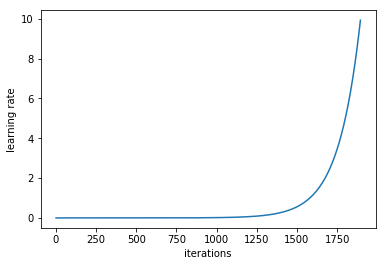

In [23]:
learn.sched.plot_lr()

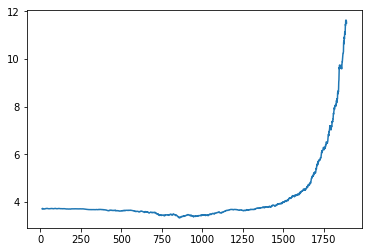

In [24]:
learn.sched.plot_loss()

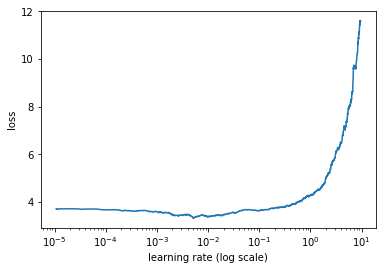

In [25]:
learn.sched.plot()

In [26]:
learn.fit(1e-4,1)

epoch      trn_loss   val_loss   accuracy                     
    0      2.945428   3.334931   0.164731  



[array([ 3.33493]), 0.16473072861668428]